In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from s import Image
import tifffile as tiff
from tensorflow.keras.utils import load_img, img_to_array

In [3]:
MODEL_TARGET = os.environ.get('MODEL_TARGET')
GCP_PROJECT = os.environ.get('GCP_PROJECT')
GCP_REGION = os.environ.get('GCP_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BQ_REGION = os.environ.get('BQ_REGION')
BQ_DATASET = os.environ.get('BQ_DATASET')
PLATE_NUMBER = os.environ.get('PLATE_NUMBER')

LOCAL_DATA_PATH = os.path.join(os.path.expanduser('~'), ".morpho_minds_data")

In [44]:
plates = ['24277', '24585', '24639']
colnames = ['Hoechst']
paths_df_Hoechst = []
cells_n = []
for platenr in plates:
    data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, platenr, 'processed', f'{platenr}_small.csv'))

    cells_n.extend(
    data_df['CellCount'].tolist()
    )

    paths_df_Hoechst.extend(
    data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Hoechst', x.split("/")[-1]))).tolist()
    )
assert(len(cells_n) == len(paths_df_Hoechst))
cells_n = np.array(cells_n)
paths_df_Hoechst = np.array(paths_df_Hoechst)

In [46]:
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df_Hoechst:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

In [47]:
base_model_score = np.sum((cells_n- cells_n.mean())**2)/data_df.shape[0]
base_model_score

2912.0902905132093

In [50]:
X_train, X_test, y_train, y_test = train_test_split(images_batch, cells_n, test_size=0.2, random_state=42)

In [51]:
def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model


In [52]:
model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/100
121/121 [==============================] - 82s 675ms/step - loss: 2228.2058 - val_loss: 793.2574
Epoch 2/100
121/121 [==============================] - 79s 656ms/step - loss: 591.1202 - val_loss: 650.6013
Epoch 3/100
121/121 [==============================] - 72s 597ms/step - loss: 396.2338 - val_loss: 364.5387
Epoch 4/100
121/121 [==============================] - 85s 702ms/step - loss: 208.9418 - val_loss: 240.6945
Epoch 5/100
121/121 [==============================] - 76s 626ms/step - loss: 161.0402 - val_loss: 152.1923
Epoch 6/100
121/121 [==============================] - 74s 612ms/step - loss: 127.3619 - val_loss: 164.0793
Epoch 7/100
121/121 [==============================] - 78s 647ms/step - loss: 116.6959 - val_loss: 232.3609
Epoch 8/100
121/121 [==============================] - 73s 603ms/step - loss: 113.5345 - val_loss: 119.2980
Epoch 9/100
121/121 [==============================] - 71s 589ms/step - loss: 92.6441 - val_loss: 101.1560
Epoch 10/100
121/121 [======

In [53]:
model.save('final_model.keras')

In [54]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 6s 124ms/step - loss: 43.2151


43.21511459350586

In [4]:
data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, PLATE_NUMBER, 'processed', f'{PLATE_NUMBER}_small.csv'))
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PhGolgi      2304 non-null   object 
 1   Hoechst      2304 non-null   object 
 2   ERSyto       2304 non-null   object 
 3   Mito         2304 non-null   object 
 4   ERSytoBleed  2304 non-null   object 
 5   CellCount    2304 non-null   int64  
 6   Well         2304 non-null   object 
 7   PhotoNumber  2304 non-null   int64  
 8   Role         2304 non-null   object 
 9   MMoles       2304 non-null   float64
 10  Plate        2304 non-null   int64  
 11  MeanArea     2304 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 216.1+ KB


In [5]:
paths_df = data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Ph_golgi', x.split('/')[-1])))

In [6]:
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

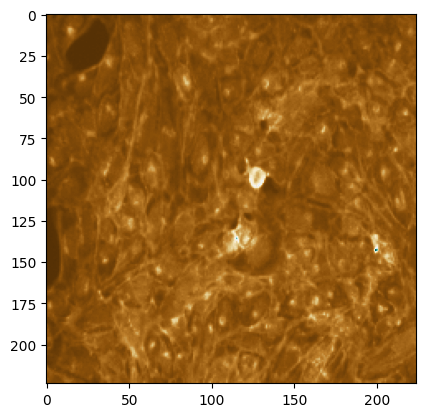

In [31]:
#images_batch/=65535
plt.imshow(images_batch[0, :, :, 0], cmap='BrBG')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['CellCount'], test_size=0.2, random_state=42)

In [33]:
base_model_score = np.sum((data_df['CellCount'] - data_df['CellCount'].mean())**2)/data_df.shape[0]
base_model_score

771.4876030815972

In [34]:
def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model

In [35]:
model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/100
41/41 [==============================] - 26s 593ms/step - loss: 2111.2537 - val_loss: 475.7352
Epoch 2/100
41/41 [==============================] - 24s 596ms/step - loss: 329.9251 - val_loss: 268.4872
Epoch 3/100
41/41 [==============================] - 23s 557ms/step - loss: 258.8506 - val_loss: 305.0244
Epoch 4/100
41/41 [==============================] - 23s 558ms/step - loss: 305.5193 - val_loss: 247.6172
Epoch 5/100
41/41 [==============================] - 26s 646ms/step - loss: 211.5432 - val_loss: 236.2696
Epoch 6/100
41/41 [==============================] - 27s 649ms/step - loss: 180.4782 - val_loss: 215.0786
Epoch 7/100
41/41 [==============================] - 24s 576ms/step - loss: 149.2499 - val_loss: 223.4454
Epoch 8/100
41/41 [==============================] - 23s 549ms/step - loss: 166.2702 - val_loss: 238.7088
Epoch 9/100
41/41 [==============================] - 23s 551ms/step - loss: 164.0302 - val_loss: 208.9904
Epoch 10/100
41/41 [=========================

In [36]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 2s 106ms/step - loss: 209.6734


209.67343139648438

1640    124
508      68
1422    111
44      231
1398    134
       ... 
1825    108
1674    132
1813    122
1776    135
2227    101
Name: CellCount, Length: 461, dtype: int64

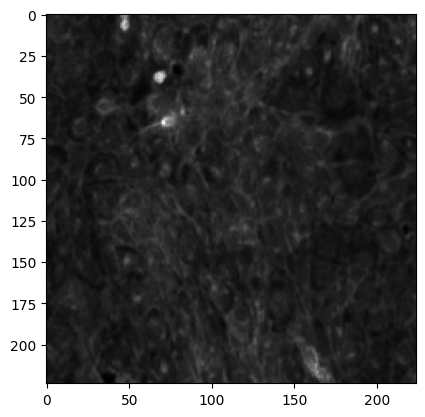

In [45]:
plt.imshow(X_test[0], cmap='gray')
y_test

In [47]:
model.predict(X_test[0].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 177ms/step


array([[127.36771]], dtype=float32)

In [49]:
paths_df = data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Hoechst', x.split('/')[-1])))
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['CellCount'], test_size=0.2, random_state=42)

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/100
41/41 [==============================] - 22s 531ms/step - loss: 2486.8242 - val_loss: 400.6823
Epoch 2/100
41/41 [==============================] - 22s 548ms/step - loss: 295.5010 - val_loss: 246.2793
Epoch 3/100
41/41 [==============================] - 23s 557ms/step - loss: 206.0064 - val_loss: 174.3896
Epoch 4/100
41/41 [==============================] - 23s 570ms/step - loss: 152.7602 - val_loss: 122.2195
Epoch 5/100
41/41 [==============================] - 23s 563ms/step - loss: 106.9774 - val_loss: 88.3748
Epoch 6/100
41/41 [==============================] - 23s 557ms/step - loss: 83.7852 - val_loss: 88.0936
Epoch 7/100
41/41 [==============================] - 23s 564ms/step - loss: 69.3428 - val_loss: 133.2310
Epoch 8/100
41/41 [==============================] - 24s 592ms/step - loss: 63.3527 - val_loss: 97.3814
Epoch 9/100
41/41 [==============================] - 23s 571ms/step - loss: 46.1638 - val_loss: 88.9212
Epoch 10/100
41/41 [==============================] -

In [53]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 2s 113ms/step - loss: 81.5905


81.59053802490234

In [52]:
model.predict(X_test[1].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 46ms/step


array([[63.7808]], dtype=float32)

In [51]:
y_test

1640    124
508      68
1422    111
44      231
1398    134
       ... 
1825    108
1674    132
1813    122
1776    135
2227    101
Name: CellCount, Length: 461, dtype: int64

In [7]:
paths_df = data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Hoechst', x.split('/')[-1])))
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['CellCount'], test_size=0.2, random_state=42)

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/100
41/41 [==============================] - 26s 606ms/step - loss: 4307.2515 - val_loss: 280.2555
Epoch 2/100
41/41 [==============================] - 23s 559ms/step - loss: 267.3056 - val_loss: 225.2388
Epoch 3/100
41/41 [==============================] - 25s 601ms/step - loss: 220.1001 - val_loss: 173.9634
Epoch 4/100
41/41 [==============================] - 24s 580ms/step - loss: 173.6908 - val_loss: 149.7757
Epoch 5/100
41/41 [==============================] - 24s 594ms/step - loss: 139.0958 - val_loss: 101.9995
Epoch 6/100
41/41 [==============================] - 27s 651ms/step - loss: 117.9641 - val_loss: 105.9738
Epoch 7/100
41/41 [==============================] - 24s 585ms/step - loss: 94.3216 - val_loss: 121.4748
Epoch 8/100
41/41 [==============================] - 25s 599ms/step - loss: 96.5588 - val_loss: 105.1310
Epoch 9/100
41/41 [==============================] - 26s 644ms/step - loss: 127.9044 - val_loss: 155.5526
Epoch 10/100
41/41 [===========================

In [8]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 2s 105ms/step - loss: 76.9374


76.9374008178711

In [50]:
batch = X_train[0:40]
layer_1 = model.layers[0]
activation_1 = layer_1(batch)
layer_2 = model.layers[2]
activation_2 = layer_2(activation_1)
layer_3 = model.layers[4]
activation_3 = layer_3(activation_2)


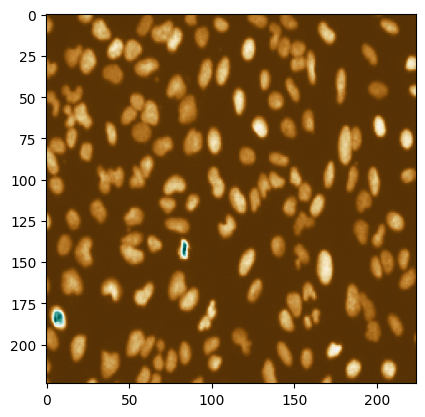

In [56]:
plt.imshow(X_train[500], cmap='BrBG')

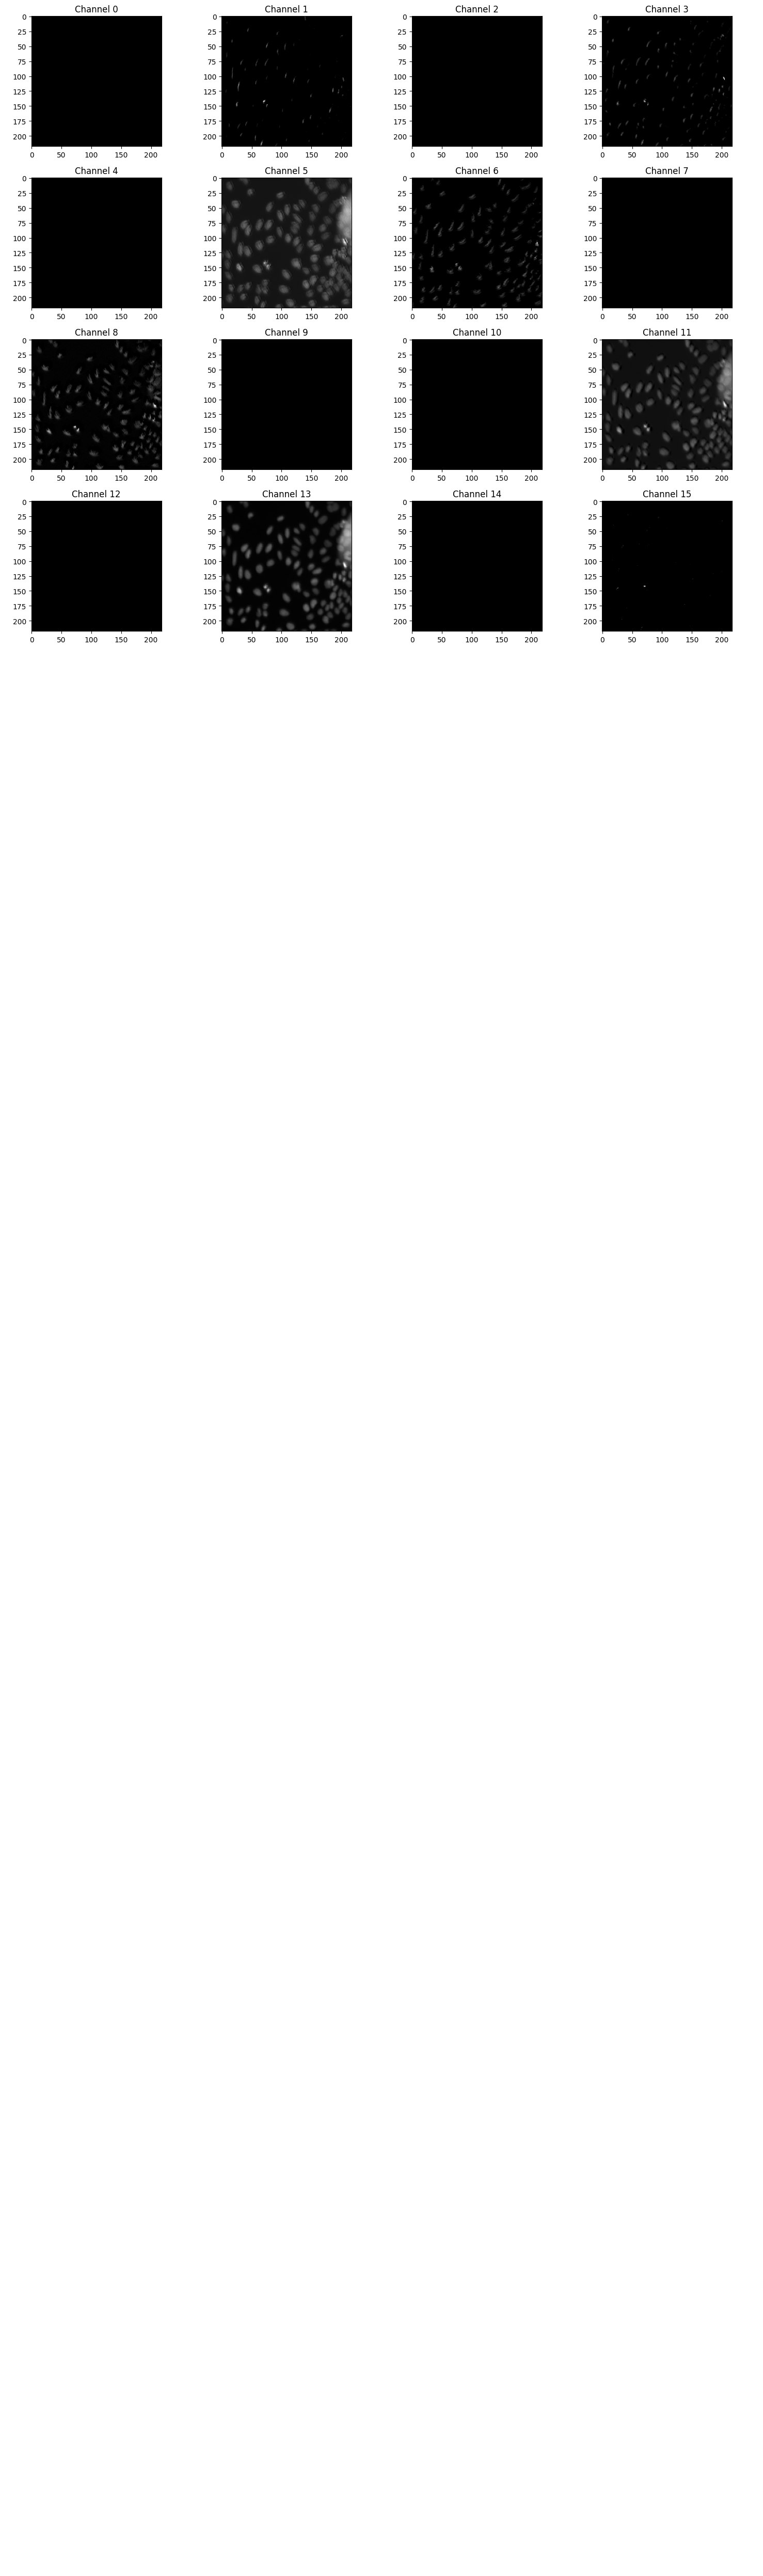

In [53]:
fig, axs = plt.subplots(16, 4, figsize=(15, 50))
for i in range(16):
    for j in range(4):
        channel_index = 4*i + j
        if channel_index < 16:  # Ensure index doesn't exceed the maximum number of channels
            feature_map = activation_3[0, :, :, channel_index]
            axs[i, j].imshow(feature_map, cmap='gray')
            axs[i, j].set_title(f'Channel {channel_index}')
        else:
            axs[i, j].axis('off')  # Turn off axis for empty plots
plt.tight_layout()
plt.show()


In [1]:
model.layers

NameError: name 'model' is not defined

In [9]:
model.save('testing_model_numbers.keras')